In [1]:
import Network as NN
import Data_Loader as DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sys
import time
import timeit
import copy
import os
import seaborn as sns

In [2]:
VAR = 0.1
scene_t = 4
vec_len = 25
lr = 0.001
batch_size = 1
acc = 0.99
out_dim = 1
Sigmoid = nn.Sigmoid()
LeakyReLU = nn.LeakyReLU(negative_slope=0.01, inplace=False)
criterion = nn.BCELoss()

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import pandas as pd
import glob

def get_summary_data(logs_dir, subfolder, network, R):
    path = f"{logs_dir}/{subfolder}/{network}/{R}/Training_Log"
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    accuracy = event_acc.Scalars("Performance / Accuracy")
    training_loss = event_acc.Scalars("Performance / Training Loss")

    data = pd.DataFrame()
    data['Wall_Time'] = [entry.wall_time for entry in accuracy]
    data['Step'] = [entry.step for entry in accuracy]
    data['Accuracy'] = [entry.value for entry in accuracy]
    data['Training_Loss'] = [entry.value for entry in training_loss]

    return data

def concatenate_logs(logs_dir, subfolder, network, R_values):
    concatenated_data = pd.DataFrame()

    for R in R_values:
        summary_data = get_summary_data(logs_dir, subfolder, network, R)
        concatenated_data = pd.concat([concatenated_data, summary_data], ignore_index=True)

    concatenated_data.to_csv(f"{logs_dir}/{subfolder}/{network}/concatenated_logs.csv", index=False)

def get_network_classes(logs_dir):
    return [os.path.basename(x) for x in glob.glob(os.path.join(logs_dir, '*')) if os.path.isdir(x)]

def get_networks(logs_dir, network_class):
    return [os.path.basename(x) for x in glob.glob(os.path.join(logs_dir, network_class, '*')) if os.path.isdir(x)]

def get_R_values(logs_dir, network_class, network):
    R_values = [os.path.basename(x) for x in glob.glob(os.path.join(logs_dir, network_class, network, '*')) if os.path.isdir(x)]
    R_values.sort(key=lambda x: int(x.split('_')[-1]))
    return R_values

In [4]:
def generate_concatenated_plot(logs_dir, network_list):
    fig, ax_loss = plt.subplots(figsize=(16, 6), dpi=600)

    for network_path in network_list:
        subfolder, network = network_path.split('/')
        R_values = get_R_values(logs_dir, subfolder, network)
        concatenated_data = pd.DataFrame()

        for R in R_values:
            summary_data = get_summary_data(logs_dir, subfolder, network, R)
            concatenated_data = pd.concat([concatenated_data, summary_data], ignore_index=True)

        ax_loss.plot(concatenated_data['Training_Loss'], label=f'{subfolder}/{network}')

    ax_loss.set_title('Training Loss')
    ax_loss.set_xlabel('Data Point')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    plt.savefig(f"{logs_dir}/concatenated_loss_plot.png")
    plt.close(fig)
    
    fig, ax_acc = plt.subplots(figsize=(16, 6), dpi=600)
    for network_path in network_list:
        subfolder, network = network_path.split('/')
        R_values = get_R_values(logs_dir, subfolder, network)
        concatenated_data = pd.DataFrame()

        for R in R_values:
            summary_data = get_summary_data(logs_dir, subfolder, network, R)
            concatenated_data = pd.concat([concatenated_data, summary_data], ignore_index=True)

        ax_acc.plot(concatenated_data['Accuracy'], label=f'{subfolder}/{network}')

    ax_acc.set_title('Accuracy')
    ax_acc.set_xlabel('Data Point')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    plt.savefig(f"{logs_dir}/concatenated_accuracy_plot.png")
    plt.close(fig)

In [5]:
def plot_R_values(ax, R_values, iteration_counts, network_class, network):
    R_plot = []
    step = 0
    for i, R in enumerate(R_values):
        R_plot.extend([i + 1] * iteration_counts[i])

    ax.plot(range(step, step + len(R_plot)), R_plot, label=f'{network_class}/{network}')
    ax.set_title('R Values')
    ax.set_xlabel('Step')
    ax.set_ylabel('R Value')
    print(network, 'generated')

def generate_R_plot(logs_dir, network_list):
    fig, ax = plt.subplots(figsize=(16, 12), dpi=600)
    for network_path in network_list:
        subfolder, network = network_path.split('/')
        R_values = get_R_values(logs_dir, subfolder, network)
        iteration_counts = []

        for R in R_values:
            summary_data = get_summary_data(logs_dir, subfolder, network, R)
            # max_step is the last step in the training log
            max_step = summary_data['Step'].tail(1).values[0]
            iteration_counts.append(max_step)
        # Plot the R_values on the shared plot
        plot_R_values(ax, R_values, iteration_counts, subfolder, network)

    ax.set_title('R Values')
    ax.set_xlabel('Step')
    ax.set_ylabel('R Value')
    ax.legend()

    plt.savefig(f"{logs_dir}/selected_networks_R_values_plot.png")
    plt.close(fig)

## selected  

### 25 scale

In [6]:
network_list = [
    'Nonl_RO/Nonl_RO-M-in25-hid50_50-eta-True-fr-4-var0.1',
    'Nonl_RO/Nonl_RO-A-in25-hid50_50-eta-True-fr-4-var0.1',
    'ML/ML-A-in25-hid50-eta-True-fr-4-var0.1',
    'ML/ML-A_M-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'ML/ML-A_A-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'ML/ML-M_M-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'ML/ML-M-in25-hid50-eta-True-fr-4-var0.1',
    'ML/ML-M_A-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_A-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_M-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-A_M-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-A_A-in25-hid25_25-eta-True_True-fr-4-var0.1',
    'Stack/Stack-M_A-in25-hid25_25-eta-True_True-fr-4-var0.1'
]

### 50 scale

In [7]:
network_list = [
    'Nonl_RO/Nonl_RO-M-in25-hid100_100-eta-True-fr-4-var0.1',    
    'Nonl_RO/Nonl_RO-A-in25-hid100_100-eta-True-fr-4-var0.1',    
    'ML/ML-A-in25-hid50-eta-True-fr-4-var0.1',
    'ML/ML-A_M-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'ML/ML-A_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'ML/ML-M_M-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'ML/ML-M-in25-hid50-eta-True-fr-4-var0.1',
    'ML/ML-M_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_M-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-A_M-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-A_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
]

### Scaling Comparison

In [41]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
import colorsys

def plot_R_values(ax, R_values, iteration_counts, network_class, network_name, color, linestyle):
    R_plot = []
    step = 0
    for i, R in enumerate(R_values):
        R_plot.extend([i + 1] * iteration_counts[i])

    # Extract numeric part from R_values and find maximum
    numeric_R_values = [int(R.split('_')[1]) for R in R_values]
    max_R = max(numeric_R_values)

    network_name = network_name.split('-eta-')[0]  # Extract the desired part of network_name

    ax.plot(range(step, step + len(R_plot)), R_plot, label=f'{network_class}/{network_name} max R:{max_R}', color=color, linestyle=linestyle)
    ax.set_title('R Values')
    ax.set_xlabel('Step')
    ax.set_ylabel('R Value')
    print(network_name, 'generated')


def generate_R_plot(logs_dir, network_list):
    fig, ax = plt.subplots(figsize=(16, 12), dpi=600)

    # Define base colors for each class
    network_classes = ['Nonl_RO', 'ML', 'Dyn_RO', 'Stack']
    base_colors = ['blue', 'blue', 'green', 'purple']

    # Define hue offsets for different networks within the same class
    #hue_offsets = [0.0, 0.05, 0.10, 0.15]
    hue_offsets = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Create a dictionary to store network names and their sizes
    network_sizes = {}

    # Create a dictionary to store network names and their unique indices for each class
    network_indices_per_class = {network_class: {} for network_class in network_classes}

    # First loop: Calculate and store network sizes
    for network_path in network_list:
        subfolder, network = network_path.split('/')
        # Extract the network size from the network name
        network_name, hid_section = network.split('-in')[0], network.split('-hid')[1]
        network_size = sum(int(size) for size in hid_section.split('-')[0].split('_'))  # sum all the hidden layer sizes

        # Store the network size in the dictionary
        if network_name not in network_sizes:
            network_sizes[network_name] = [network_size]
        else:
            network_sizes[network_name].append(network_size)

    # Second loop: Generate the plot
    for network_path in network_list:
        subfolder, network = network_path.split('/')
        network_name, hid_section = network.split('-in')[0], network.split('-hid')[1]
        # Update network indices within each class
        if network_name not in network_indices_per_class[subfolder]:
            network_indices_per_class[subfolder][network_name] = len(network_indices_per_class[subfolder])

        R_values = get_R_values(logs_dir, subfolder, network)
        iteration_counts = []

        for R in R_values:
            summary_data = get_summary_data(logs_dir, subfolder, network, R)
            max_step = summary_data['Step'].tail(1).values[0]
            iteration_counts.append(max_step)

        # Define color and line style
        base_color = base_colors[network_classes.index(subfolder)]
        # Create a gradient color based on the base color and the network name
        hls_color = list(colorsys.rgb_to_hls(*mcolors.to_rgb(base_color)))
        hls_color[0] = (hls_color[0] + hue_offsets[network_indices_per_class[subfolder][network_name]%len(hue_offsets)]) % 1 
        color = colorsys.hls_to_rgb(*hls_color)

        # Determine the line style based on the network size
        network_size = sum(int(size) for size in network.split('-hid')[1].split('-')[0].split('_'))  # sum all the hidden layer sizes
        if network_size == max(network_sizes[network_name]):
            linestyle = '-'  # solid line for the largest size
        else:
            linestyle = ':'  # dotted line for smaller sizes

        # Plot the R_values on the shared plot
        plot_R_values(ax, R_values, iteration_counts, subfolder, network, color, linestyle)

    ax.set_title('R Values')
    ax.set_xlabel('Step')
    ax.set_ylabel('R Value')
    ax.legend()
    
    plt.savefig(f"{logs_dir}/selected_networks_R_values_plot.png")
    plt.close(fig)


In [42]:
network_list = [   
    'Nonl_RO/Nonl_RO-M-in25-hid50_50-eta-1-fr-4-var0.1',    
    'Nonl_RO/Nonl_RO-M-in25-hid100_100-eta-1-fr-4-var0.1',    
    'Nonl_RO/Nonl_RO-A-in25-hid50_50-eta-1-fr-4-var0.1',
    'Nonl_RO/Nonl_RO-A-in25-hid100_100-eta-1-fr-4-var0.1',    
    'ML/ML-M-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-M-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
]

In [43]:
network_list = [      
    'ML/ML-M-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-M-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-A_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-A_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-A_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-A_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
]

ML-M
ML-M-in25-hid100 generated
ML-M


KeyboardInterrupt: 

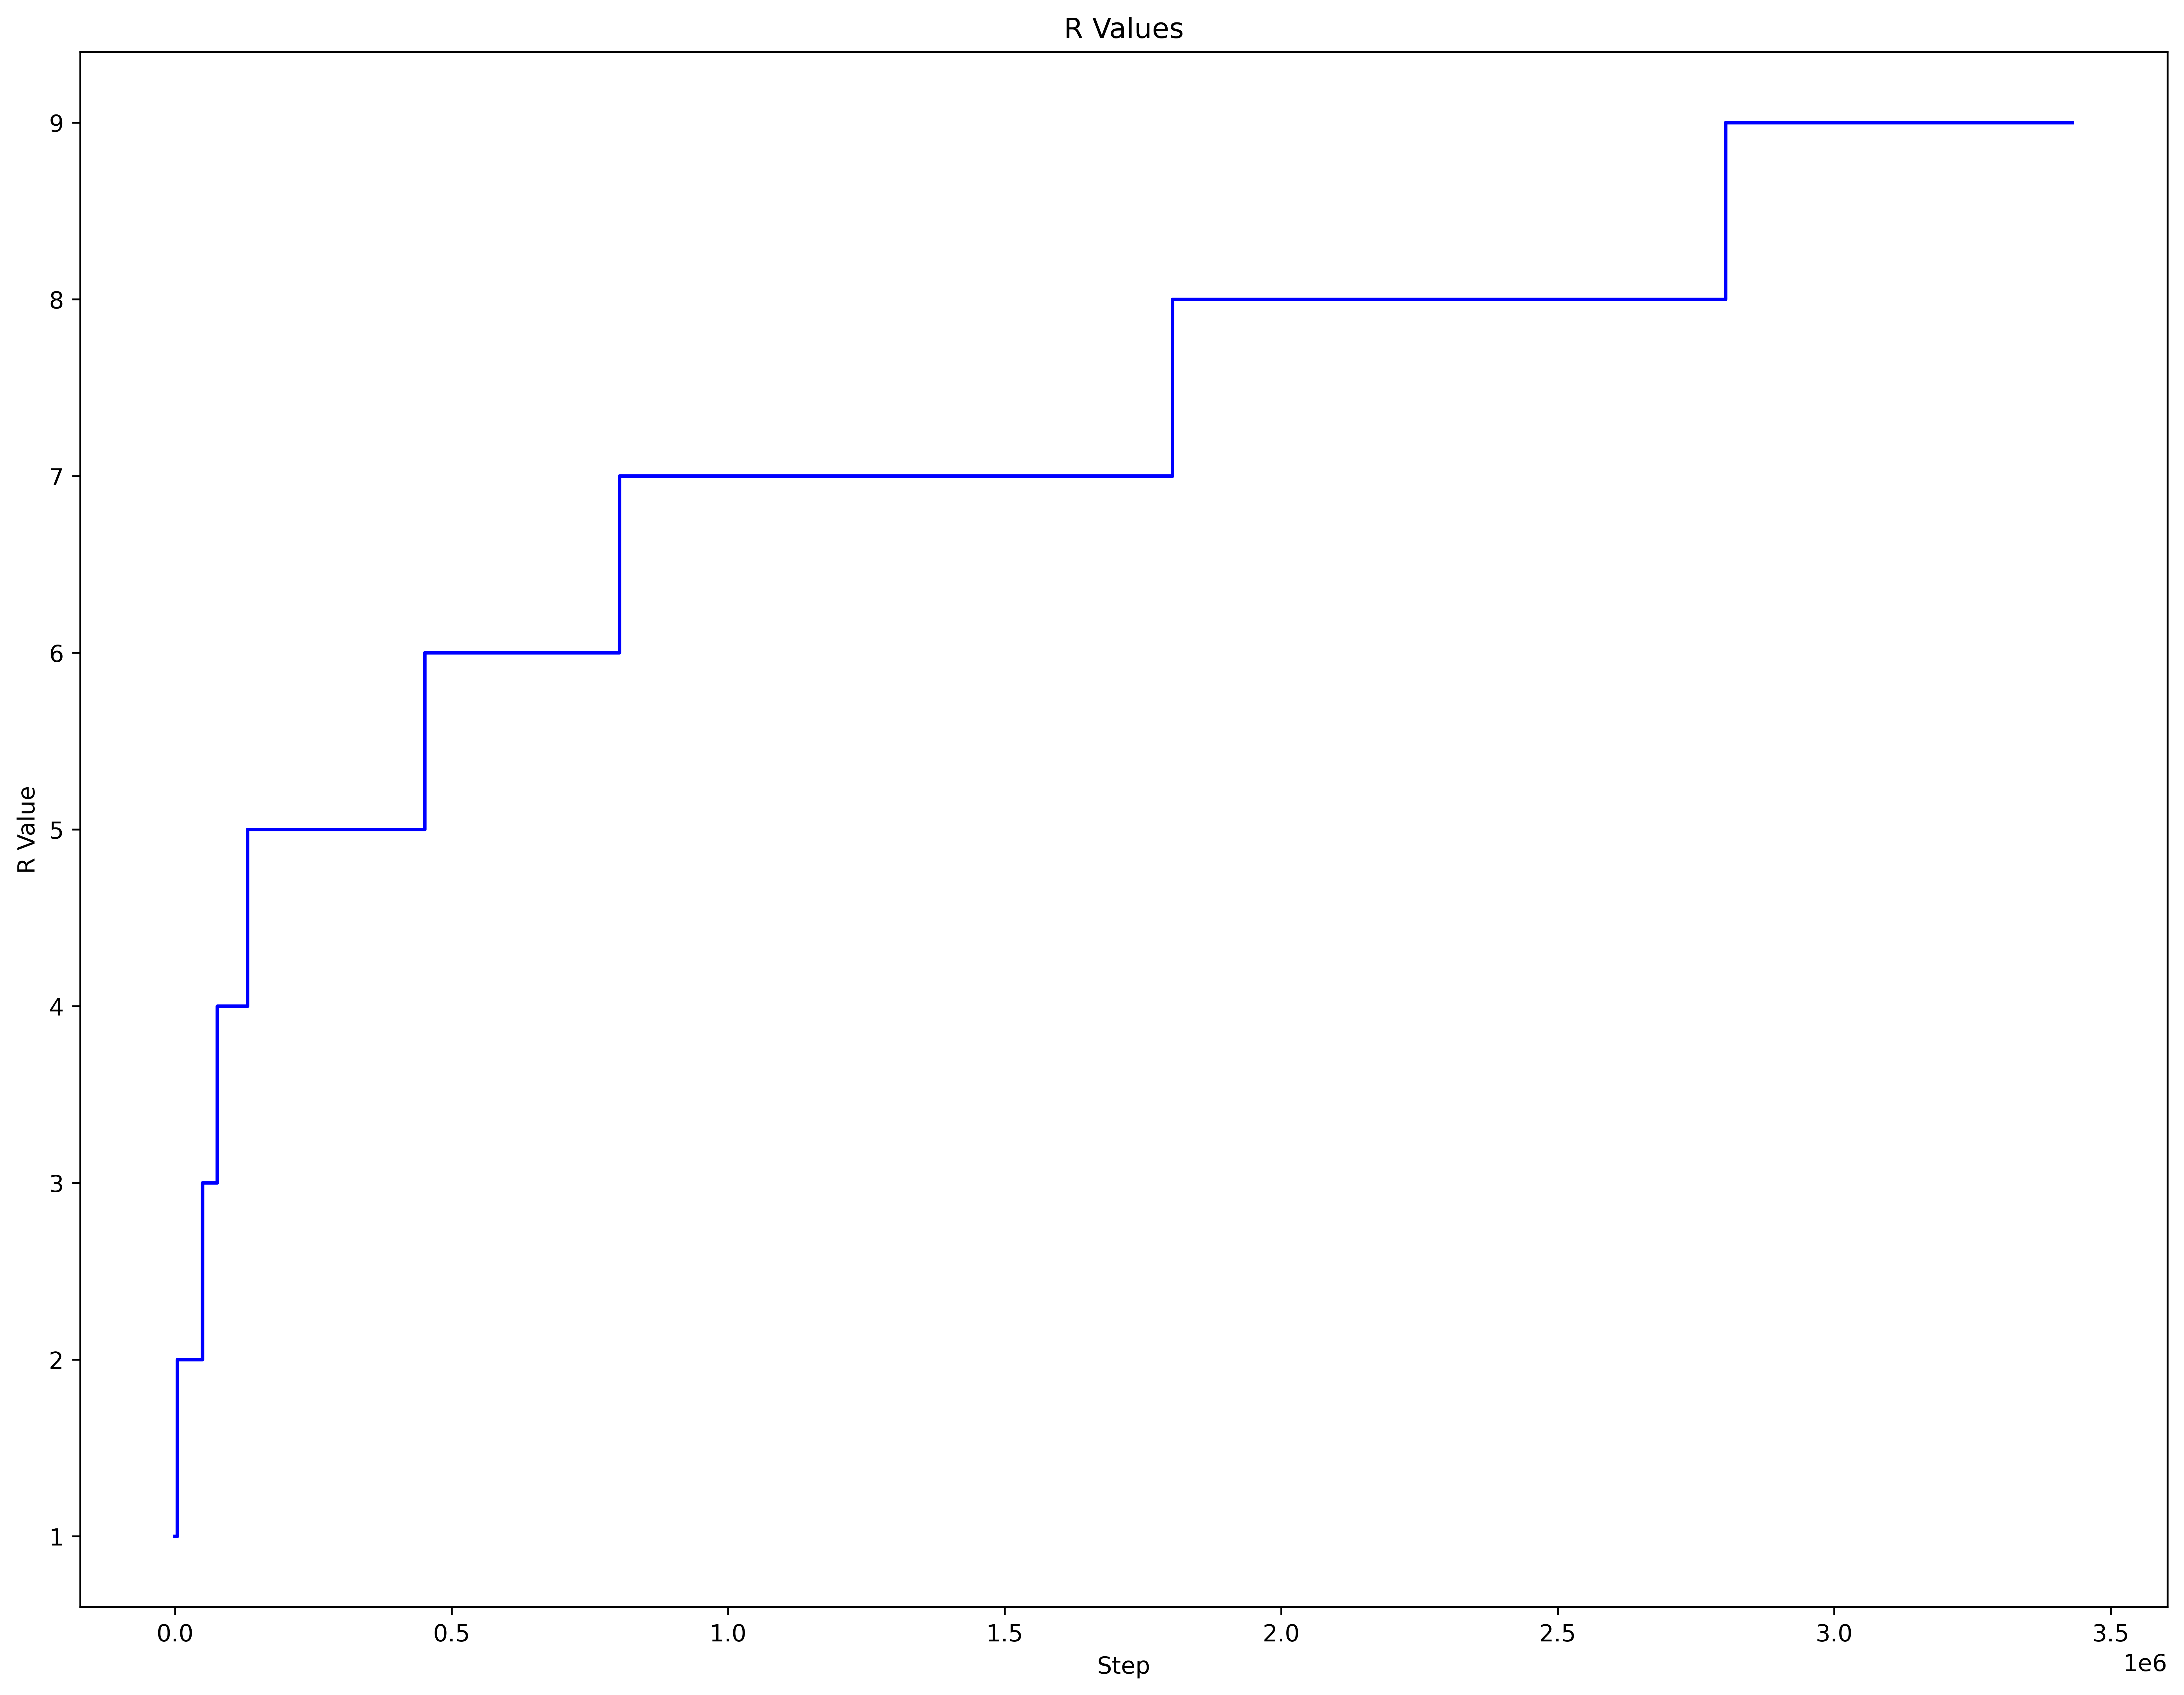

In [44]:
logs_dir = os.getcwd() + '/Result'

# Generate R value plots
generate_R_plot(logs_dir, network_list)
print("R value plot for selected networks has been generated.")

In [8]:
network_list = [
    'ML/ML-M_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
    'Dyn_RO/Dyn_RO-M_A-in25-hid50_50-eta-True_True-fr-4-var0.1',
]

In [8]:
generate_concatenated_plot(logs_dir, network_list)
print("Concatenated loss/acc plot for specified networks has been generated.")

Concatenated loss/acc plot for specified networks has been generated.


## Bar Plot


In [45]:
import matplotlib.pyplot as plt
import os

def plot_bar_values(ax, R_values, iteration_counts, network_class, network_name, color):
    # Extract numeric part from R_values and find maximum
    numeric_R_values = [int(R.split('_')[1]) for R in R_values]
    max_R = max(numeric_R_values)
    network_name = network_name.split('-eta-')[0]  # Extract the desired part of network_name
    ax.bar(network_name, max_R, color=color, label=f'{network_class}/{network_name} max R:{max_R}')
    print(network_name, 'generated')


def generate_bar_plot(logs_dir, network_list):
    fig, ax = plt.subplots(figsize=(16, 12), dpi=600)

    # Define base colors for each class
    color_dict = {'A': 'green', 'M': 'red', 'M_A': 'red','M_M': 'red','A_A': 'green','A_M': 'green'}

    # First loop: Generate the plot
    for network_path in network_list:
        subfolder, network = network_path.split('/')
        network_name, hid_section = network.split('-in')[0], network.split('-hid')[1]

        R_values = get_R_values(logs_dir, subfolder, network)
        iteration_counts = []

        for R in R_values:
            summary_data = get_summary_data(logs_dir, subfolder, network, R)
            max_step = summary_data['Step'].tail(1).values[0]
            iteration_counts.append(max_step)

        # Define color based on the network name
        color = color_dict[network_name.split('-')[1]]

        # Plot the R_values on the shared plot
        plot_bar_values(ax, R_values, iteration_counts, subfolder, network, color)

    ax.set_title('R Values')
    ax.set_xlabel('Network')
    ax.set_ylabel('Max R Value')
    ax.legend()
    
    plt.savefig(f"{logs_dir}/bar_plots.png")
    plt.close(fig)


In [46]:
network_list = [      
    'ML/ML-M-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-M-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid100-eta-1-fr-4-var0.1',
    'ML/ML-A-in25-hid50-eta-1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-M_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-A_A-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-A_A-in25-hid50_50-eta-1_1-fr-4-var0.1',
    'ML/ML-A_M-in25-hid25_25-eta-1_1-fr-4-var0.1',
    'ML/ML-A_M-in25-hid50_50-eta-1_1-fr-4-var0.1',
]

In [47]:
logs_dir = os.getcwd() + '/Result'

# Generate R value plots
generate_bar_plot(logs_dir, network_list)
print("R value plot for selected networks has been generated.")

? ML-M-in25-hid100-eta-1-fr-4-var0.1
ML-M-in25-hid100 generated
? ML-M-in25-hid50-eta-1-fr-4-var0.1
ML-M-in25-hid50 generated
? ML-A-in25-hid100-eta-1-fr-4-var0.1
ML-A-in25-hid100 generated
? ML-A-in25-hid50-eta-1-fr-4-var0.1
ML-A-in25-hid50 generated
? ML-M_A-in25-hid25_25-eta-1_1-fr-4-var0.1
ML-M_A-in25-hid25_25 generated
? ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1
ML-M_A-in25-hid50_50 generated
? ML-M_M-in25-hid25_25-eta-1_1-fr-4-var0.1
ML-M_M-in25-hid25_25 generated
? ML-M_M-in25-hid50_50-eta-1_1-fr-4-var0.1
ML-M_M-in25-hid50_50 generated
? ML-A_A-in25-hid25_25-eta-1_1-fr-4-var0.1
ML-A_A-in25-hid25_25 generated
? ML-A_A-in25-hid50_50-eta-1_1-fr-4-var0.1
ML-A_A-in25-hid50_50 generated
? ML-A_M-in25-hid25_25-eta-1_1-fr-4-var0.1
ML-A_M-in25-hid25_25 generated
? ML-A_M-in25-hid50_50-eta-1_1-fr-4-var0.1
ML-A_M-in25-hid50_50 generated
R value plot for selected networks has been generated.


## SVD

In [62]:
import re

def parse_dir(dir_path):
    # Extract hid_dim_list
    hid_dim_list = list(map(int, re.findall(r'hid(\d+)', dir_path)))

    # Extract hetero_list
    hetero_list = list(map(int, re.findall(r'eta-(\d)', dir_path)))

    # Extract plastic_list
    plastic_list = re.findall(r'[A-Z]_([A-Z])', dir_path)
    plastic_list = [char for char in plastic_list]

    # Extract network_name
    network_name = re.findall(r'(\w+)/', dir_path)[0]

    return hid_dim_list, hetero_list, plastic_list, network_name

# Example use:
dir_path = '/Users/leon66/Desktop/Neuroscience/Movie_remote/Result/ML/ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1/R_14/Model'
hid_dim_list, hetero_list, plastic_list, network_name = parse_dir(dir_path)

print(f"hid_dim_list: {hid_dim_list}")
print(f"hetero_list: {hetero_list}")
print(f"plastic_list: {plastic_list}")
print(f"network_name: {network_name}")


hid_dim_list: [50]
hetero_list: [1]
plastic_list: ['A']
network_name: Users


In [23]:
model_dir = '/Users/leon66/Desktop/Neuroscience/Movie_remote/Result/ML/ML-M_A-in25-hid50_50-eta-1_1-fr-4-var0.1/R_14/Model'
hid_dim_list = [50,50]
hetero_list = [1,1]
plastic_list =['M','A']
network_name = 'ML'
model = NN.network_selector(input_dim=vec_len, hid_dim_list=hid_dim_list, out_dim=out_dim, hetero_list=hetero_list, plastic_list=plastic_list, network_name=network_name)
model.load_state_dict(torch.load(model_dir))
model.eval()


ML(
  (lambda_list): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
  )
  (weight_matrix_list): ParameterList(
      (0): Parameter containing: [torch.float32 of size 50x25]
      (1): Parameter containing: [torch.float32 of size 50x50]
  )
  (bias_matrix_list): ParameterList(
      (0): Parameter containing: [torch.float32 of size 50x1]
      (1): Parameter containing: [torch.float32 of size 50x1]
  )
  (eta_matrix_list): ParameterList(
      (0): Parameter containing: [torch.float32 of size 50x25]
      (1): Parameter containing: [torch.float32 of size 50x50]
  )
)

In [50]:
model_dir = 'Result/ML/ML-A-in25-hid100-eta-0.5-fr-4-var0.1/R_5/Model'
hid_dim_list = [100]
hetero_list = [0.5]
plastic_list =['A']
network_name = 'ML'
model = NN.network_selector(input_dim=vec_len, hid_dim_list=hid_dim_list, out_dim=out_dim, hetero_list=hetero_list, plastic_list=plastic_list, network_name=network_name)
model.load_state_dict(torch.load(model_dir))
model.eval()

ML(
  (lambda_list): ParameterList(  (0): Parameter containing: [torch.float32 of size ])
  (weight_matrix_list): ParameterList(  (0): Parameter containing: [torch.float32 of size 100x25])
  (bias_matrix_list): ParameterList(  (0): Parameter containing: [torch.float32 of size 100x1])
  (eta_matrix_list): ParameterList(  (0): Parameter containing: [torch.float32 of size 100x1])
)

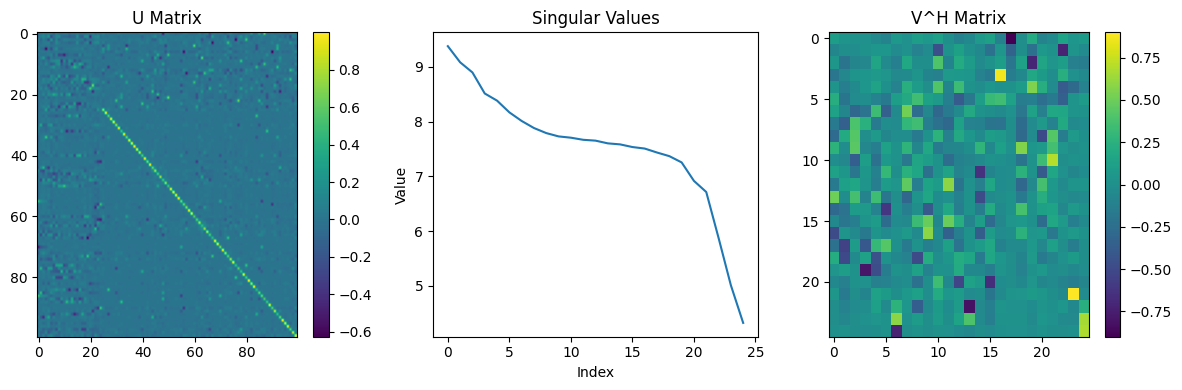

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume your weight_matrix_list is a list of numpy arrays.
weight_matrix_list = model.weight_matrix_list
weight_matrix = weight_matrix_list[0].detach().numpy()

# Perform SVD
u, s, vh = np.linalg.svd(weight_matrix)

# Plot singular values
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(u, aspect='auto', cmap='viridis')
plt.title("U Matrix")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.plot(s)
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Value")

plt.subplot(1, 3, 3)
plt.imshow(vh, aspect='auto', cmap='viridis')
plt.title("V^H Matrix")
plt.colorbar()

plt.tight_layout()
plt.show()


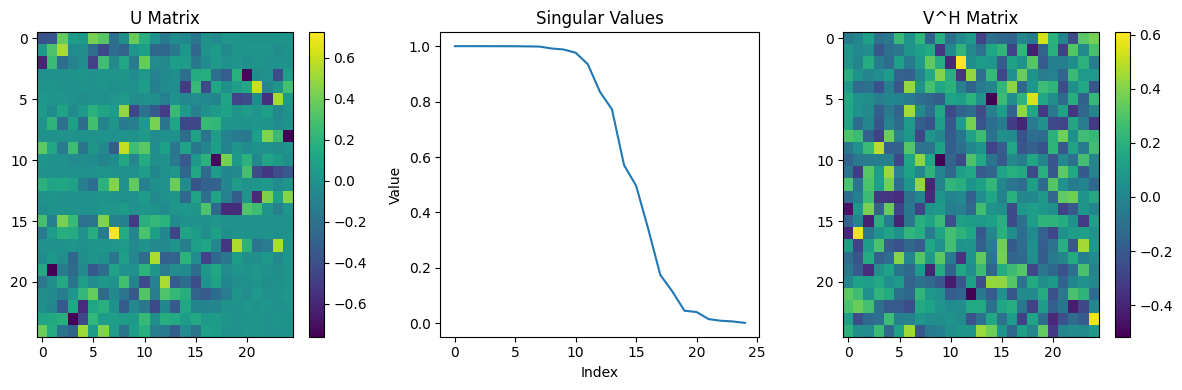

In [43]:
# Perform SVD
u, s, vh = np.linalg.svd(u[25:,25:])

# Plot singular values
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(u, aspect='auto', cmap='viridis')
plt.title("U Matrix")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.plot(s)
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Value")

plt.subplot(1, 3, 3)
plt.imshow(vh, aspect='auto', cmap='viridis')
plt.title("V^H Matrix")
plt.colorbar()

plt.tight_layout()
plt.show()


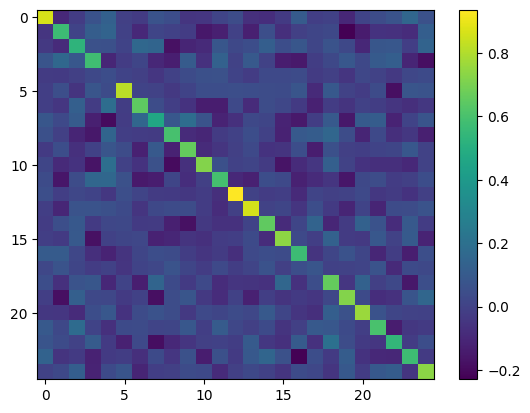

In [34]:
plt.imshow(u[25:,25:], aspect='auto', cmap='viridis')
plt.colorbar()

In [35]:
u[25:,25:]

array([[ 8.66568029e-01, -9.45504606e-02, -2.20807474e-02,
         6.55215681e-02,  1.26741737e-01, -9.33176372e-03,
        -2.86583826e-02,  6.70563579e-02,  4.70398180e-02,
        -4.72223014e-02, -4.47497405e-02,  8.84474441e-03,
         4.36490737e-02, -6.95106834e-02, -7.61013478e-02,
        -3.20505351e-02,  1.03335582e-01, -1.51690682e-02,
        -6.19678479e-03, -1.01641521e-01,  4.70759114e-03,
         4.31885608e-02,  6.72605261e-02,  1.57491654e-01,
         6.19465858e-02],
       [-4.84788977e-02,  5.67765892e-01,  5.60034206e-03,
         1.13167867e-01,  1.43634960e-01, -3.54382978e-03,
        -9.36959162e-02,  1.51641257e-02, -5.24857361e-03,
        -2.10051686e-02, -1.55437991e-01, -1.28710657e-01,
        -3.89861944e-03, -1.27154753e-01,  5.06197773e-02,
        -7.12518618e-02, -8.47092457e-03,  1.39958328e-02,
         2.34794803e-02, -2.29297981e-01, -1.42463416e-01,
        -5.82427941e-02, -6.48591742e-02, -8.35825279e-02,
         1.21242747e-01],
    

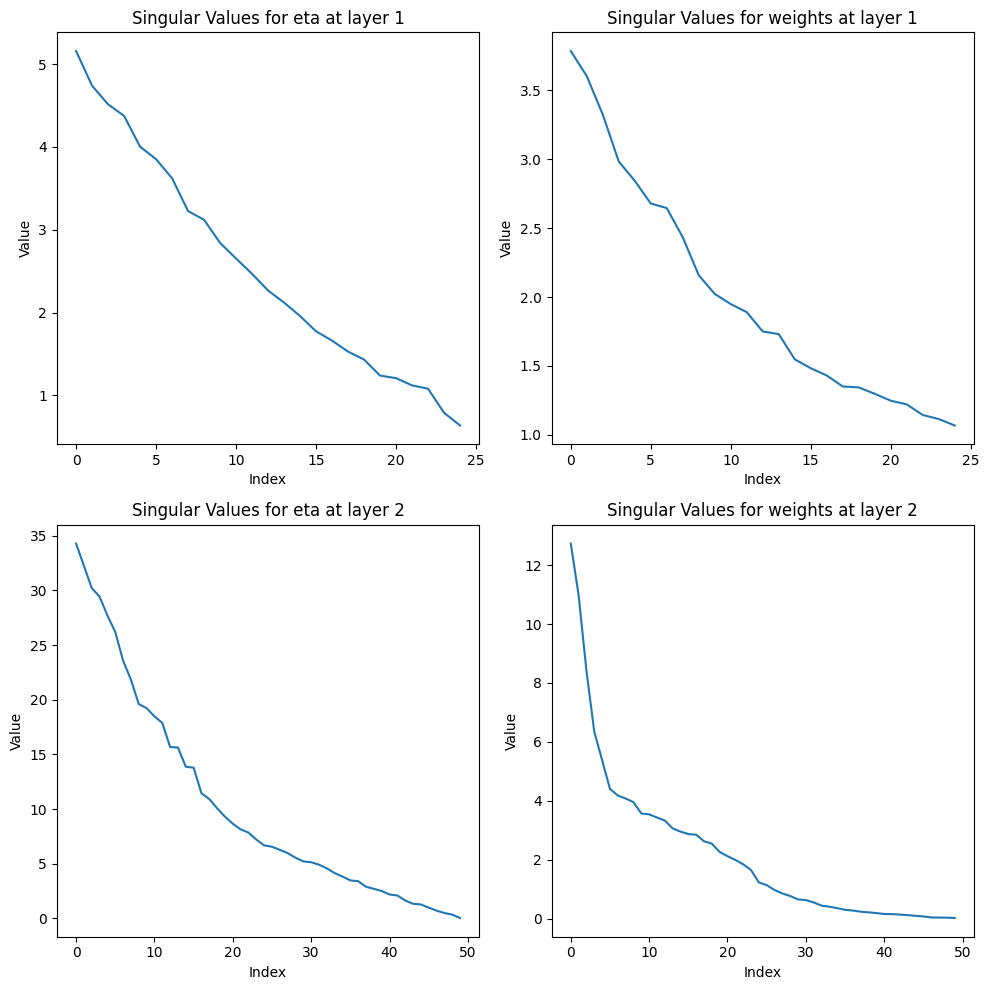

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume your weight_matrix_list and eta_matrix_list are lists of numpy arrays.
eta_matrix_list = model.eta_matrix_list
weight_matrix_list = model.weight_matrix_list

# Make sure there are two matrices in each list
assert len(eta_matrix_list) == 2
assert len(weight_matrix_list) == 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# SVD for eta_matrix_list
for idx, eta_matrix in enumerate(eta_matrix_list):
    eta_matrix = eta_matrix.detach().numpy()
    u, s, vh = np.linalg.svd(eta_matrix)
    axes[idx, 0].plot(s)
    axes[idx, 0].set_title(f"Singular Values for eta at layer {idx+1}")
    axes[idx, 0].set_xlabel("Index")
    axes[idx, 0].set_ylabel("Value")

# SVD for weight_matrix_list
for idx, weight_matrix in enumerate(weight_matrix_list):
    weight_matrix = weight_matrix.detach().numpy()
    u, s, vh = np.linalg.svd(weight_matrix)
    axes[idx, 1].plot(s)
    axes[idx, 1].set_title(f"Singular Values for weights at layer {idx+1}")
    axes[idx, 1].set_xlabel("Index")
    axes[idx, 1].set_ylabel("Value")

plt.tight_layout()
plt.show()

In [12]:
u

array([[-4.82273251e-01,  1.10172525e-01, -7.80284226e-01, ...,
        -5.26137138e-03, -1.82839436e-03, -3.63166980e-03],
       [-2.32233163e-02, -2.89533590e-03,  4.16343752e-03, ...,
         3.01273376e-01,  8.95346552e-02, -1.94434598e-01],
       [ 2.79777055e-03,  7.64065364e-04, -1.48672843e-02, ...,
        -4.60008532e-02,  1.72303438e-01, -1.09772459e-01],
       ...,
       [-1.80422422e-02, -1.61292460e-02,  5.20280749e-03, ...,
         5.40973902e-01, -1.99536793e-02,  4.63992395e-02],
       [ 1.64977163e-02,  1.13267712e-02,  5.65426843e-03, ...,
        -9.87704694e-02,  5.72686970e-01, -3.27362679e-02],
       [ 1.57223903e-02,  6.26138644e-03, -1.85620524e-02, ...,
         1.07992396e-01, -5.08167930e-02,  7.35449314e-01]], dtype=float32)